In [1]:
#run this to access data from drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Wrangle and process data

In [2]:
import numpy as np
import pandas as pd

#Read independent variable CSV
#Add a shortcut to the LRM Project folder to your drive if you get an error
df_pred = pd.read_csv("LRM_macro_data(v0.2)_20241210.csv")
df_pred['Month'] = pd.to_datetime(df_pred['Month'], format='%b-%y')

#remove rows with any missing data
df_pred = df_pred[~df_pred.isnull().any(axis=1)]

#Check data
#print(df_pred.head(-5))


#data source: https://www.investing.com/indices/us-spx-500-historical-data
df_sp500 = pd.read_csv('S&P 500 Historical Data.csv').drop('Vol.',axis=1)
df_sp500['Date'] = pd.to_datetime(df_sp500['Date'])

"""
Note: this data returns the values at the given date plus the %change over the previous month
we should be using the previous months data to predict the %change on the first of the next month?
e.g. We use Jan-11 CPI, EFFR, etc, to predict %change of Feb-11
-Sam
"""
df_sp500['Predictors Date'] = df_sp500['Date']-pd.DateOffset(months=1)
#print(df_sp500.head())

#Create boolean variable denoting an increase
df_sp500['Increase'] = np.where(df_sp500['Change %'].str.replace('%','').astype(float) > 0, True, False)

#check data
#print(df_sp500.head(-5))

#Merge Data set
df = pd.merge(df_pred,df_sp500, how = 'left', left_on = 'Month', right_on = 'Predictors Date')

#Create X, Y from processed Data
X = df[['CPI','EFFR','GDP(%)','Unemployment Rate','WTI','FX_EUR','FX_CNY']]
Y = df['Increase']

perc_inc = df['Increase'].mean()
print(f'{perc_inc}% of months showed an increase in percent change')

0.6666666666666666% of months showed an increase in percent change


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Check for variable patterns

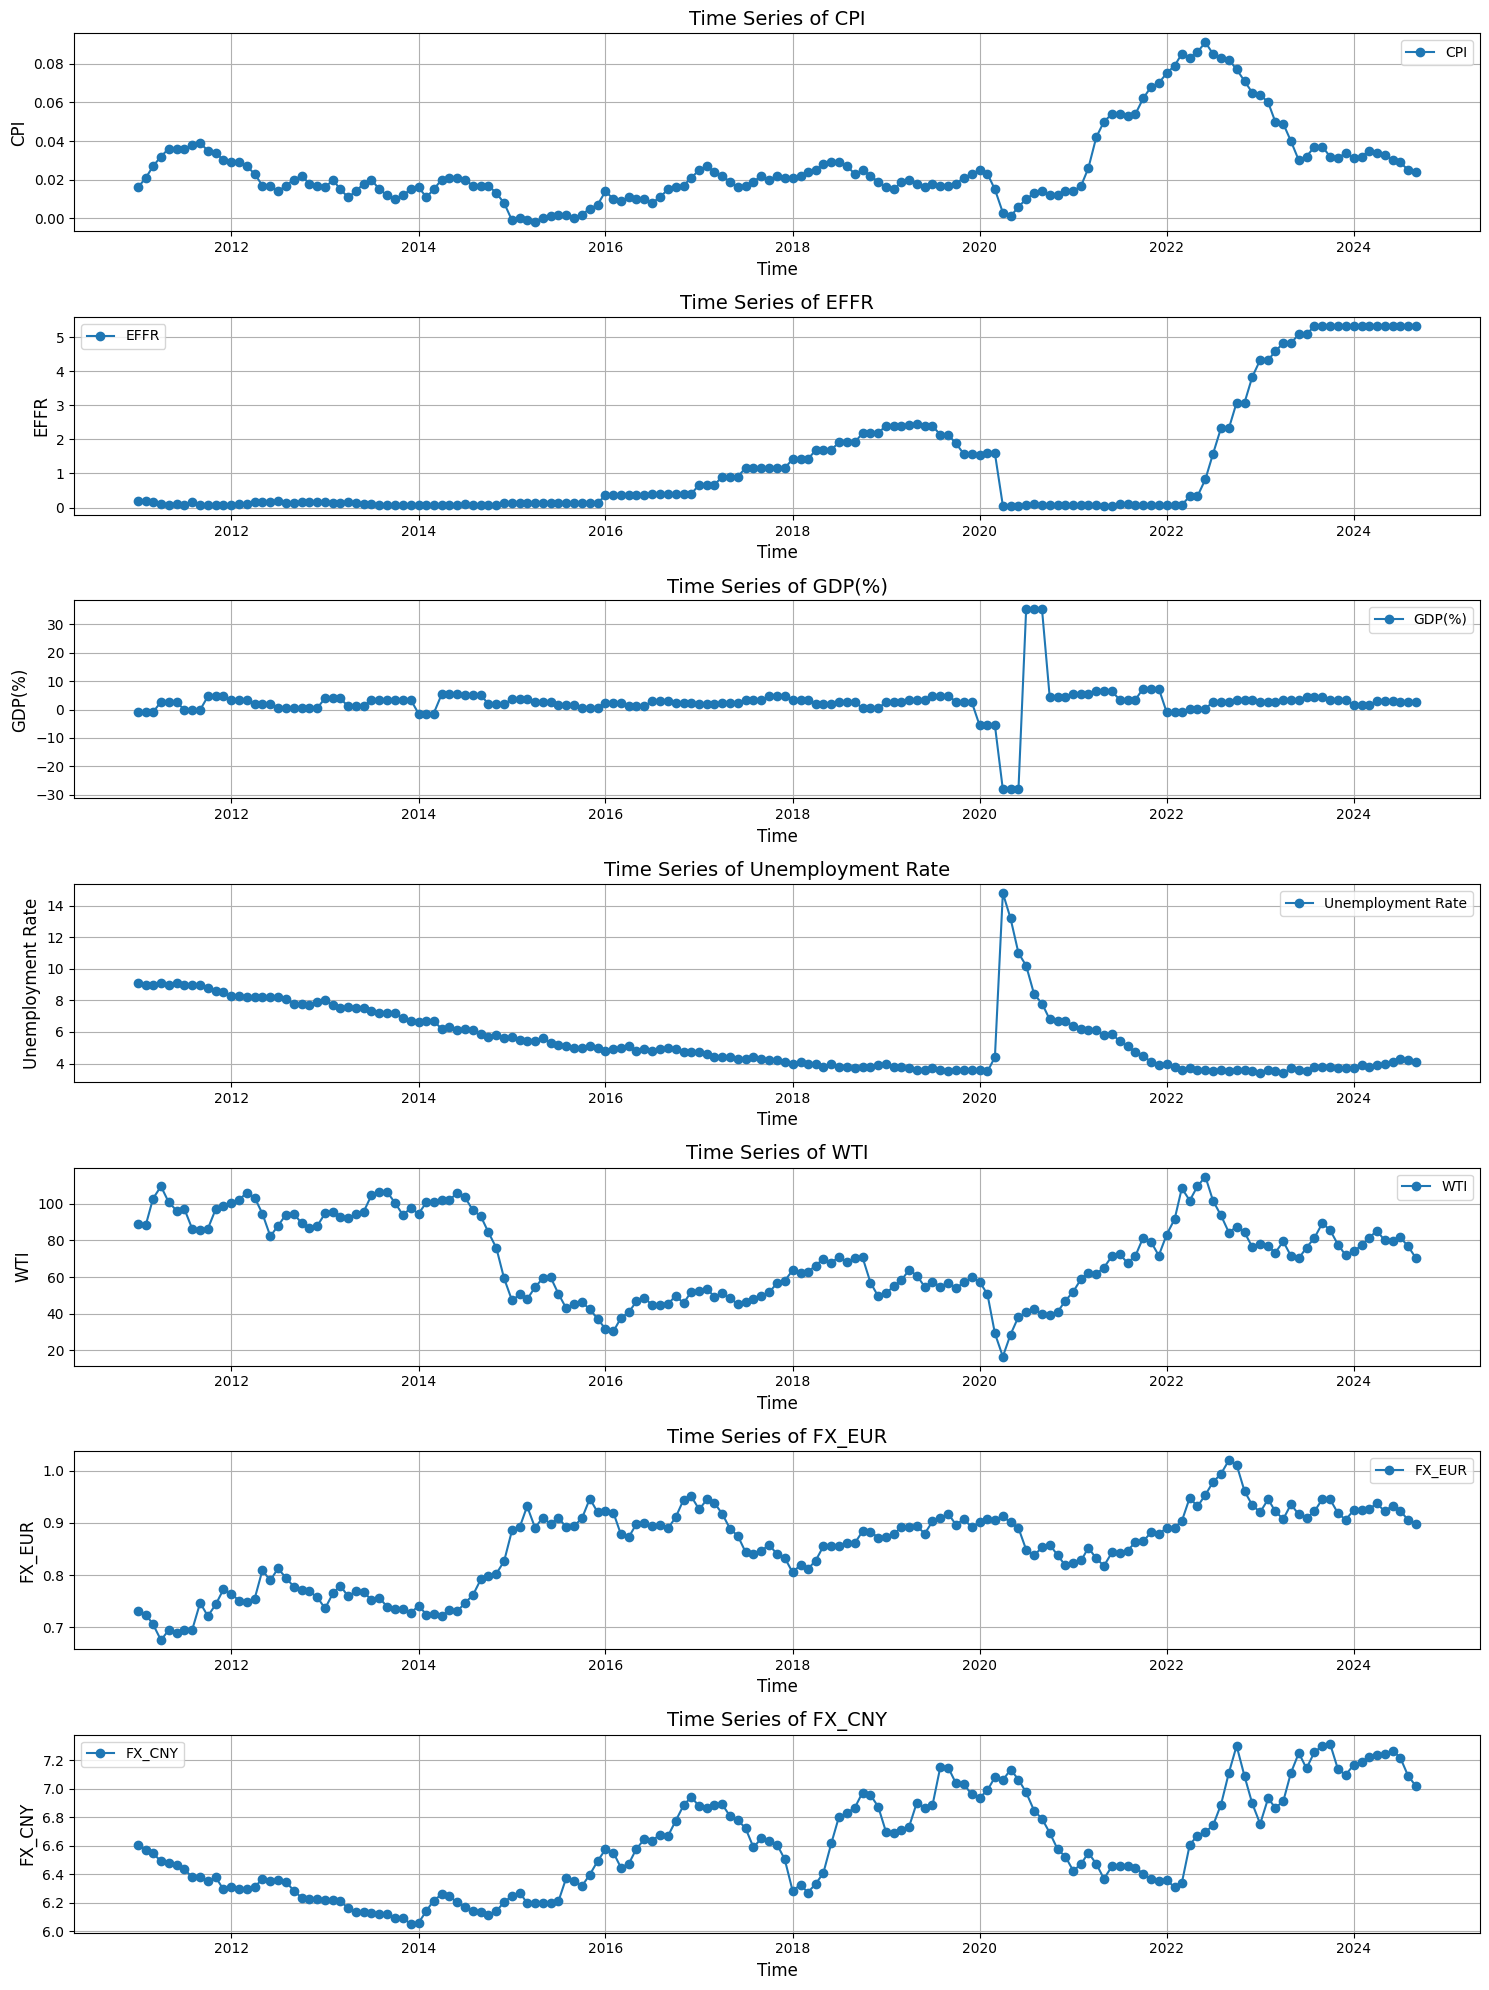

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set 'Month' as the index for easier plotting
df.set_index('Month', inplace=True)

# List of variables for time series plots
variables = ['CPI', 'EFFR', 'GDP(%)', 'Unemployment Rate', 'WTI', 'FX_EUR', 'FX_CNY']

# Create time series plots for each variable
plt.figure(figsize=(15, 20))
for i, var in enumerate(variables, start=1):
    plt.subplot(len(variables), 1, i)
    plt.plot(df.index, df[var], label=var, marker='o')
    plt.title(f'Time Series of {var}', fontsize=14)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel(var, fontsize=12)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

Check for Correlations

                        CPI      EFFR    GDP(%)  Unemployment Rate       WTI  \
CPI                1.000000  0.251815  0.052687          -0.337327  0.451312   
EFFR               0.251815  1.000000  0.017529          -0.556532  0.008775   
GDP(%)             0.052687  0.017529  1.000000          -0.183887  0.043174   
Unemployment Rate -0.337327 -0.556532 -0.183887           1.000000  0.177452   
WTI                0.451312  0.008775  0.043174           0.177452  1.000000   
FX_EUR             0.272073  0.519860 -0.066155          -0.658506 -0.502894   
FX_CNY             0.220785  0.758473 -0.060308          -0.400989 -0.326405   

                     FX_EUR    FX_CNY  
CPI                0.272073  0.220785  
EFFR               0.519860  0.758473  
GDP(%)            -0.066155 -0.060308  
Unemployment Rate -0.658506 -0.400989  
WTI               -0.502894 -0.326405  
FX_EUR             1.000000  0.687909  
FX_CNY             0.687909  1.000000  


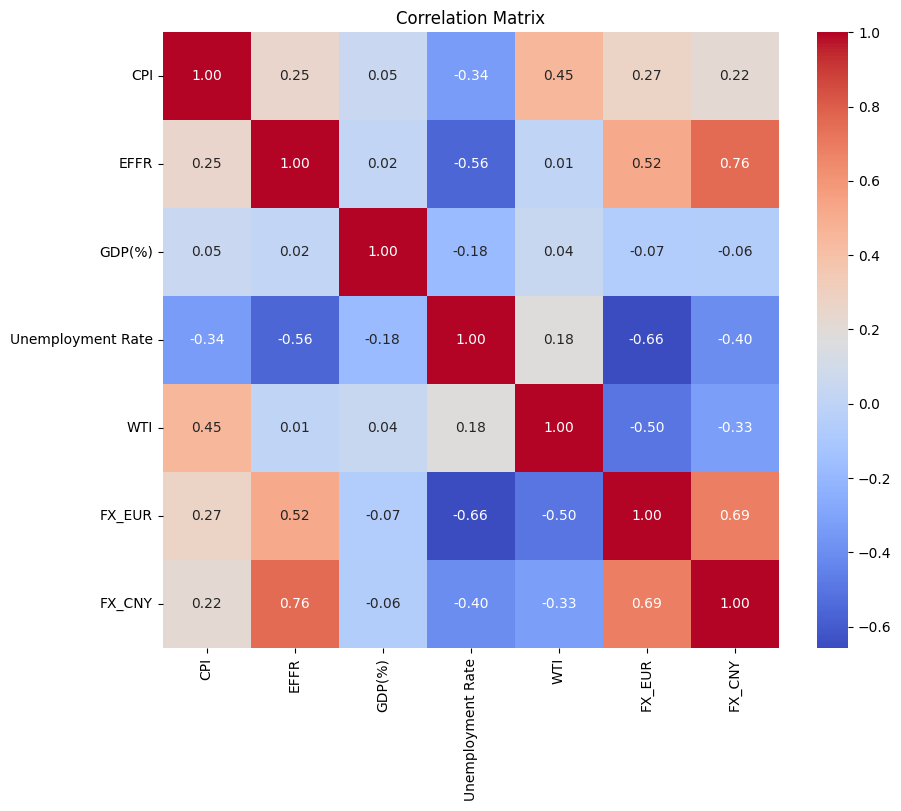

In [5]:
import pandas as pd

# Assuming X is the DataFrame with the specified variables
correlation_matrix = X.corr()

# Display the correlation matrix
print(correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.show()

Start of Models

In [3]:
#Import relevant scikitlearn functions
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

#Create cross validation data set with 5 groups. Use stratified Kfold to
#keep same proportion of up and down in each group

"""
Important consideration: this removes all time series aspects of this data set.
We should discuss this in our findings. We are making a strong assumption here that
there is some sort of memoryless process from month to month where the %increase only
depends on the existing conditions of the given month. We should try to find some evidence
that could justify this assumption with even with the understanding we are losing some information
by removing the time ordering. Our interpretation should be that this is cross sectional
evaluation of correlation between different independednt model states and observed "up" or "down"
results. I don't think we should draw any causal relationships.
-Sam
"""

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=6)

Start testing. All of our scoring is based on accuracy, i.e., correct predictions over total predictions

In [ ]:
#Logistic Regression

[0.66666667 0.66666667 0.63636364 0.60606061 0.66666667]


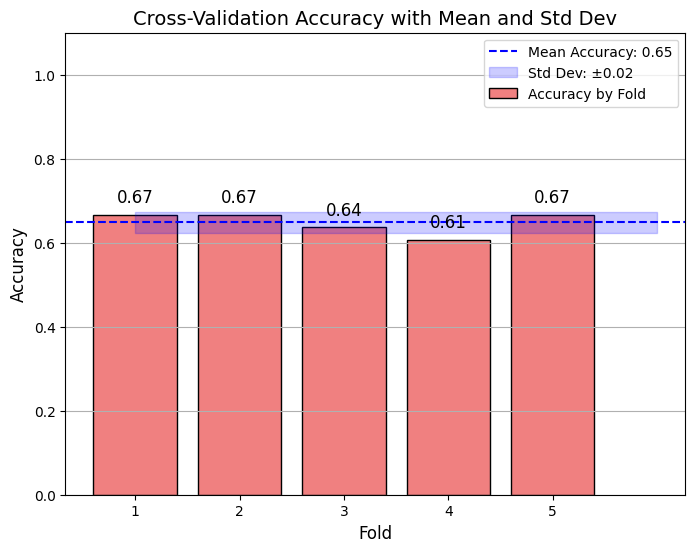

In [13]:
from sklearn.linear_model import LogisticRegression

#Create model increase max_iter if cross_val_does not converge
logModel = LogisticRegression(solver='lbfgs', max_iter=5000)

#use CV fold, get scores as accuracy
logScores = cross_val_score(logModel, X, Y, cv=cv, scoring='accuracy')
print(logScores)

# Calculate mean and standard deviation
mean_score = np.mean(logScores)
std_score = np.std(logScores)

# Plot accuracy scores with mean line
plt.figure(figsize=(8, 6))
bars = plt.bar(range(1, len(logScores) + 1), logScores, color='lightcoral', edgecolor='black', label='Accuracy by Fold')

# Add the accuracy score as text on each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,  # Adjusted position higher
             f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=12, color='black')  # Larger font size

# Plot the mean line
plt.axhline(mean_score, color='blue', linestyle='--', label=f'Mean Accuracy: {mean_score:.2f}')

# Plot the standard deviation range
plt.fill_between(range(1, len(logScores) + 2),
                 mean_score - std_score,
                 mean_score + std_score,
                 color='blue', alpha=0.2, label=f'Std Dev: ±{std_score:.2f}')

# Add titles, labels, and legend
plt.title("Cross-Validation Accuracy with Mean and Std Dev", fontsize=14)
plt.xlabel("Fold", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(range(1, len(logScores) + 1))
plt.ylim(0, 1.1)  # Increased y-axis limit for better spacing
plt.legend()
plt.grid(axis='y')

# Show the plot
plt.show()

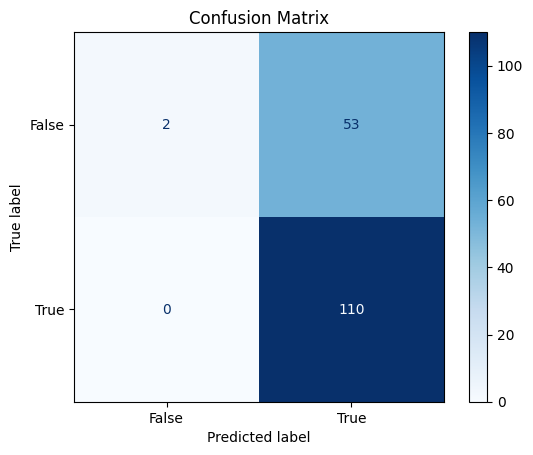

In [14]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Fit the model on the full dataset
logModel.fit(X, Y)
Y_pred = logModel.predict(X)

# Compute and plot the confusion matrix
cm = confusion_matrix(Y, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logModel.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

The model produces too much "Trues" >> Needs improvement

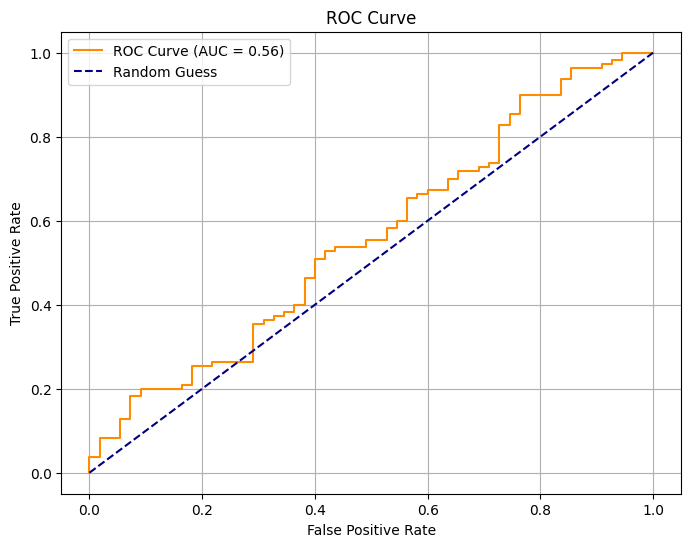

In [15]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities
Y_prob = logModel.predict_proba(X)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(Y, Y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label="Random Guess")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

In [23]:
#To solve too many "Trues"
# Oversampling the Minority Class

from imblearn.over_sampling import SMOTE

# Perform SMOTE
smote = SMOTE(random_state=6)
X_resampled, Y_resampled = smote.fit_resample(X, Y)

# Train the logistic regression model on the resampled data
logModel2.fit(X_resampled, Y_resampled)

logScores2 = cross_val_score(logModel2, X, Y, cv=cv, scoring='accuracy')
print(logScores2)

#Even worse result

[0.45454545 0.54545455 0.39393939 0.33333333 0.57575758]


In [26]:
#Optimize the hyperparameters of logistic regression to improve its performance
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Regularization strength
    'solver': ['lbfgs', 'liblinear'],
}

# Perform grid search
grid_search = GridSearchCV(LogisticRegression(max_iter=5000), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, Y)

# Best model
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

from sklearn.linear_model import LogisticRegression

# Create the logistic regression model with the best parameters
optimized_logModel = LogisticRegression(C=10, solver='lbfgs', max_iter=5000)

# Fit the model to the training data
optimized_logModel.fit(X, Y)

#use CV fold, get scores as accuracy
optimized_logScores = cross_val_score(optimized_logModel, X, Y, cv=cv, scoring='accuracy')
print(optimized_logScores)


# Similar to the first result, use a different method

Best Parameters: {'C': 10, 'solver': 'lbfgs'}
[0.60606061 0.66666667 0.63636364 0.60606061 0.66666667]


Note this does not beat the mean. Options for improvement: try regularization

In [ ]:
#KNN Classification

In [17]:
from sklearn.neighbors import KNeighborsClassifier

#Create model using 5 nearest neighbors
knnModel = KNeighborsClassifier()

#Search grid for best number of nearest neighbors
param_grid = {
            'n_neighbors':[1,2,3,4,5,6,7,8,9,10]
}

knnGrid_search = GridSearchCV(estimator=knnModel, param_grid=param_grid, cv=cv, scoring='accuracy')

knnGrid_search.fit(X,Y)
#print(knnGrid_search.cv_results_)
print('K neighbors for best result')
print(knnGrid_search.best_params_)
print(f'Score for {knnGrid_search.best_params_}')
print(knnGrid_search.best_score_)

K neighbors for best result
{'n_neighbors': 9}
Score for {'n_neighbors': 9}
0.6181818181818182


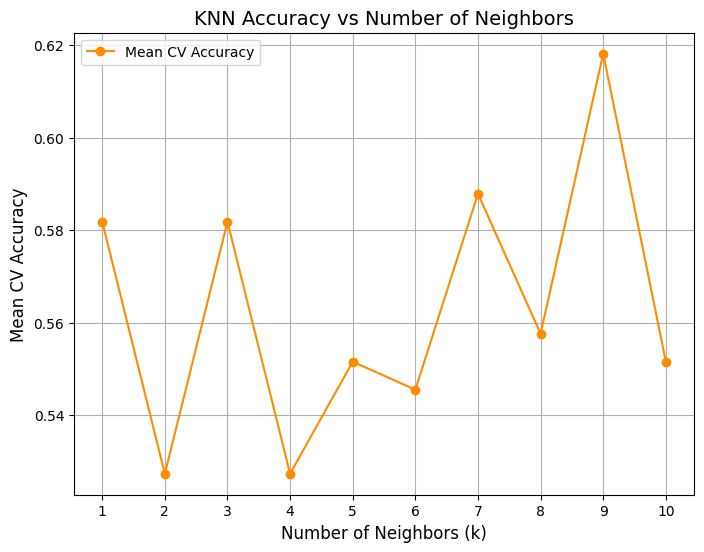

In [18]:
# Extract results from GridSearchCV
mean_scores = knnGrid_search.cv_results_['mean_test_score']
n_neighbors = param_grid['n_neighbors']

# Plot accuracy vs number of neighbors
plt.figure(figsize=(8, 6))
plt.plot(n_neighbors, mean_scores, marker='o', color='darkorange', label='Mean CV Accuracy')
plt.title("KNN Accuracy vs Number of Neighbors", fontsize=14)
plt.xlabel("Number of Neighbors (k)", fontsize=12)
plt.ylabel("Mean CV Accuracy", fontsize=12)
plt.grid()
plt.xticks(n_neighbors)
plt.legend()
plt.show()

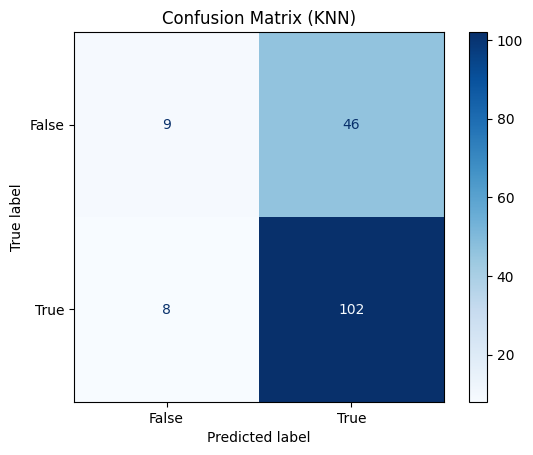

In [19]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Fit the KNN model with the best parameters
best_knn = knnGrid_search.best_estimator_
Y_pred_knn = best_knn.predict(X)

# Compute and plot confusion matrix
cm = confusion_matrix(Y, Y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_knn.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (KNN)")
plt.show()

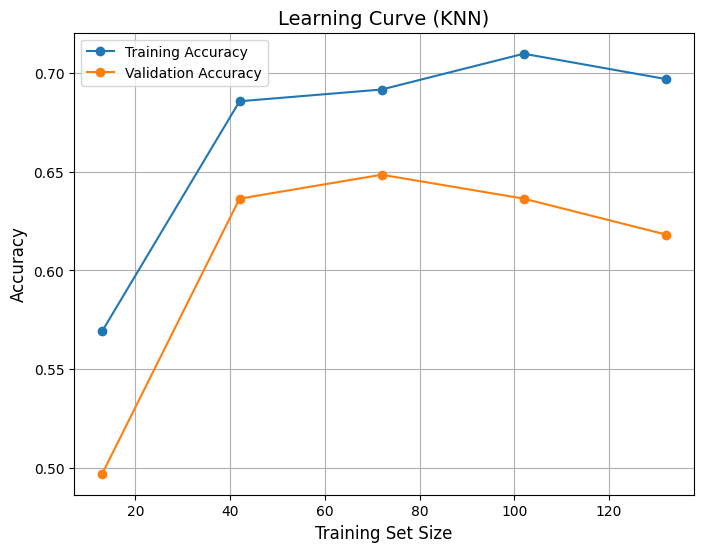

In [20]:
#Evaluate how the performance of the KNN model changes with the size of the training dataset.
from sklearn.model_selection import learning_curve

# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(best_knn, X, Y, cv=cv, scoring='accuracy')
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, marker='o', label="Training Accuracy")
plt.plot(train_sizes, test_mean, marker='o', label="Validation Accuracy")
plt.title("Learning Curve (KNN)", fontsize=14)
plt.xlabel("Training Set Size", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid()
plt.show()

Quite bad, some even worse than 50-50 guess. Options for improvement:
grid search for optimal n_neighbors?

In [ ]:
#LDA

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

ldaModel = LinearDiscriminantAnalysis()

ldaScores = cross_val_score(ldaModel, X, Y, cv=cv, scoring='accuracy')
print(np.mean(ldaScores))

0.618181818181818


Also not great

In [ ]:
#SVM

In [ ]:
from sklearn.svm import SVC

svmModel = SVC()

param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [1, 0.1, 0.01, 0.001]  # Kernel coefficient
}

# Grid search with cross-validation
svmGrid = GridSearchCV(svmModel, param_grid, cv=cv, scoring='accuracy')
svmGrid.fit(X, Y)

print('K neighbors for best result')
print(svmGrid.best_params_)
print(f'Score for {svmGrid.best_params_}')
print(svmGrid.best_score_)

#svmScores = cross_val_score(svmModel, X, Y, cv=cv, scoring='accuracy')
#print(svmScores)

Gradient Boosting

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score

# Create the Gradient Boosting model
gbModel = GradientBoostingClassifier(random_state=6)

# Define a parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
    'max_depth': [3, 4, 5],  # Depth of the trees
    'subsample': [0.8, 1.0],  # Fraction of samples to fit each tree
    'min_samples_split': [2, 5],  # Minimum number of samples to split
}

# Perform grid search
gbGrid_search = GridSearchCV(estimator=gbModel, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the model
gbGrid_search.fit(X, Y)

# Display best parameters and score
print("Best Parameters:", gbGrid_search.best_params_)
print("Best Cross-Validation Score:", gbGrid_search.best_score_)

# Extract the best model
best_gbModel = gbGrid_search.best_estimator_

# Train the model on the full dataset
best_gbModel.fit(X, Y)

# Predict on the training data
Y_pred_gb = best_gbModel.predict(X)

# Evaluate the model
print("Accuracy:", accuracy_score(Y, Y_pred_gb))
print("Classification Report:\n", classification_report(Y, Y_pred_gb))


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 50, 'subsample': 1.0}
Best Cross-Validation Score: 0.6787878787878787
Accuracy: 0.696969696969697
Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.09      0.17        55
        True       0.69      1.00      0.81       110

    accuracy                           0.70       165
   macro avg       0.84      0.55      0.49       165
weighted avg       0.79      0.70      0.60       165



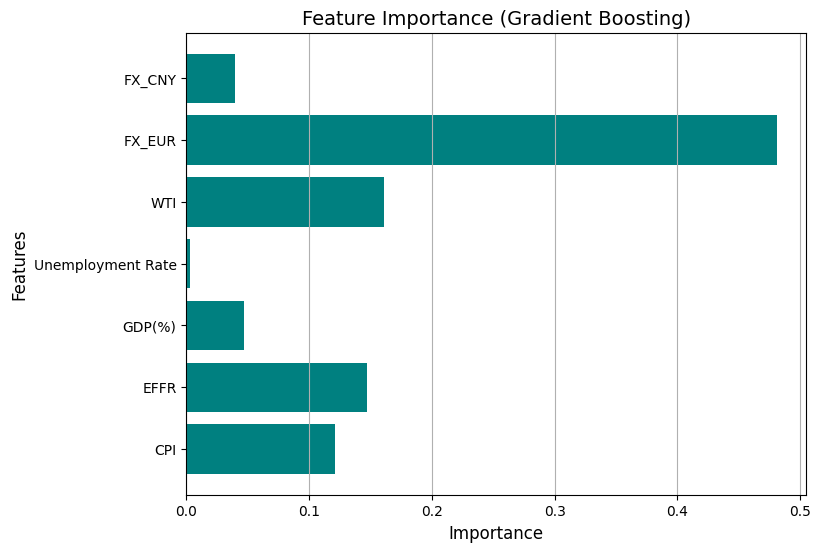

In [28]:
# Get feature importances
feature_importances = best_gbModel.feature_importances_
features = X.columns

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(features, feature_importances, color='teal')
plt.title("Feature Importance (Gradient Boosting)", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.grid(axis='x')
plt.show()

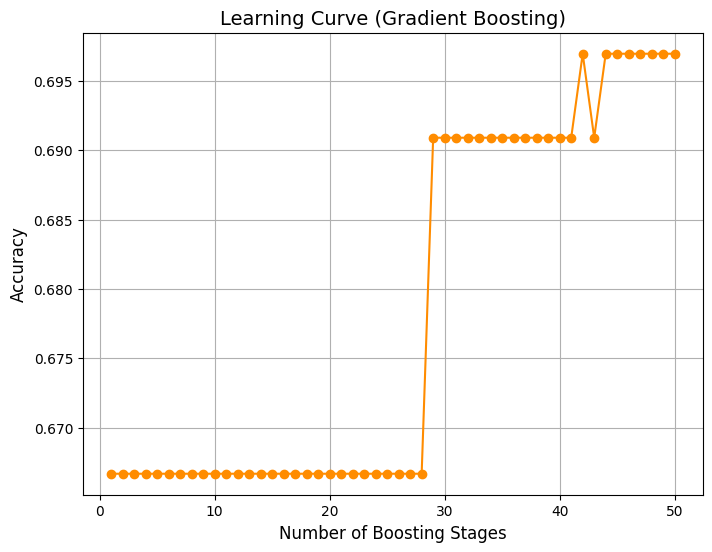

In [29]:
# Get staged predictions
staged_scores = [accuracy_score(Y, pred) for pred in best_gbModel.staged_predict(X)]

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(staged_scores) + 1), staged_scores, marker='o', color='darkorange')
plt.title("Learning Curve (Gradient Boosting)", fontsize=14)
plt.xlabel("Number of Boosting Stages", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid()
plt.show()

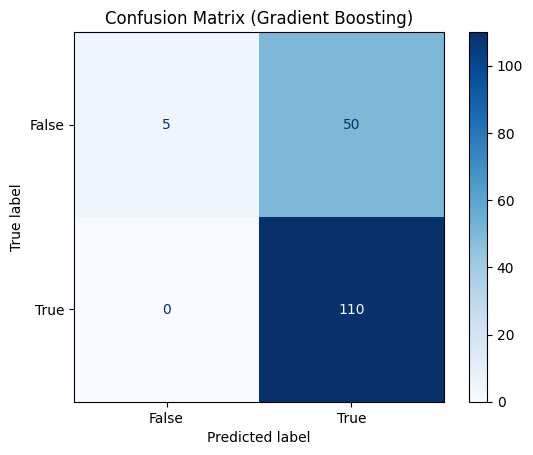

In [30]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute and plot confusion matrix
cm = confusion_matrix(Y, Y_pred_gb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_gbModel.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Gradient Boosting)")
plt.show()

Best model but does not beat mean. Options for hyperparameter tuning from chatgpt below that we could try to implement.

In [ ]:

# Define parameter grid


Seems we can not beat the mean. Discuss the efficient market hypothesis in our analysis?